<a href="https://colab.research.google.com/github/davidalvarez03/Polynomials/blob/main/JAX_Polynomial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import tensorflow_probability.substrates.jax as tfp
import jax
from scipy.optimize import minimize
from jax import random
import optax
from jax import numpy as jnp
import optax
tfd = tfp.distributions

In [2]:
!pip install corner
from corner import corner

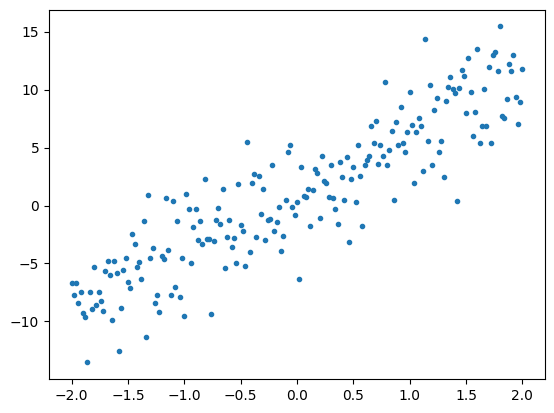

In [3]:
# The true parameters
TRUE_W = 5.0
TRUE_B = 1.0
NUM_DATA = 201

# A vector of random x values
x = jnp.linspace(-2,2, NUM_DATA)

def f(x):
  return x * TRUE_W + TRUE_B

mean=0
std=3

# Generate some noise
noise = mean + std*jax.random.normal(key = random.PRNGKey(1),shape=[NUM_DATA],)

# Calculate y
y = f(x) + noise

# Plot all the data
plt.plot(x, y, '.')
plt.show()

In [4]:
jnp.polyfit(x,y,1)

Array([4.9222054, 1.0407368], dtype=float32)

In [5]:
# class MyModel():
#   def __init__(self,w_initial,b_initial):
#     super().__init__()
#     # Initialize the weights to `5.0` and the bias to `0.0`
#     # In practice, these should be randomly initialized
#     self.w = jnp.array(w_initial)
#     self.b = jnp.array(b_initial)

#   def __call__(self, x):
#     return self.w * x + self.b

In [6]:
#DEFINING THE PRIOR, LIKELIHOOD AND POSTERIOR

p_w=tfd.Uniform(-5,5)
p_b=tfd.Uniform(-5,5)


def logprior(theta):
    p_w=tfd.Normal(4.5,3)
    p_b=tfd.Normal(1.5,3)
    return p_w.log_prob(theta[0])+p_b.log_prob(theta[1])



def loglikelihood(theta):
    print('*')
    predicted_y=theta[0]*x+theta[1]
    ll = jax.numpy.sum(jax.scipy.stats.norm.logpdf(predicted_y, loc=y, scale=std))
    return ll

def logposterior(theta):
  return logprior(theta)+loglikelihood(theta)

def loss(theta):
  return -logposterior(theta)

In [7]:
jacobian = jax.jacfwd(loss)
hessian = jax.hessian(loss)

In [8]:
theta=jnp.array([5.0,0.0])

In [9]:
print(f'Jacobian : {jacobian(theta)} \n')
print(f'Hessian: {hessian(theta)}')

*
Jacobian : [  2.3952816 -23.40978  ] 

*
Hessian: [[ 3.0186665e+01 -9.9092722e-07]
 [-9.9092722e-07  2.2444443e+01]]


In [10]:
theta_start=jnp.array([0.0,0.0])
res1 = minimize(loss, theta_start, method = 'BFGS',
	       options={'disp': True,'gtol': 1e-3}, jac = jacobian) # Tolerance added to aid in convergence
print("Convergence Achieved: ", res1.success)
print("Number of Function Evaluations: ", res1.nfev)

*
*
*
*
*
*
*
*
*
*
*
*
Optimization terminated successfully.
         Current function value: 497.970490
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Convergence Achieved:  True
Number of Function Evaluations:  6


In [11]:
print(res1)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 497.9704895019531
        x: [ 4.921e+00  1.043e+00]
      nit: 5
      jac: [ 7.015e-04  2.284e-04]
 hess_inv: [[ 3.327e-02  6.460e-05]
            [ 6.460e-05  4.458e-02]]
     nfev: 6
     njev: 6


In [12]:
theta_map=res1.x

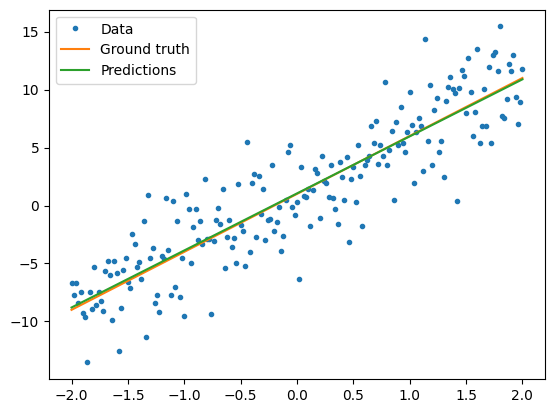

*
Current loss: 497.970490


In [13]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, theta_map[0]*x+theta_map[1], label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(theta_map))

In [14]:
import functools
import time

import jax.random
import optax
import tensorflow_probability.substrates.jax as tfp
from jax import jit, pmap
from jax import numpy as jnp
from tensorflow_probability.substrates.jax import (
    distributions as tfd,
    bijectors as tfb,
    experimental as tfe,
)
from tqdm.auto import trange


In [15]:
def SVI(
        start,
        optimizer: optax.GradientTransformation,
        n_vi=250,
        init_scales=1e-3,
        num_steps=500,
        seed=0,
    ):
        dev_cnt = jax.device_count()
        seeds = jax.random.split(jax.random.PRNGKey(seed), dev_cnt)
        n_vi = (n_vi // dev_cnt) * dev_cnt
        scale = (
            jnp.diag(jnp.ones(jnp.size(start))) * init_scales
            if jnp.size(init_scales) == 1
            else init_scales
        )
        cov_bij = tfp.bijectors.FillScaleTriL(diag_bijector=tfp.bijectors.Exp(), diag_shift=1e-6)
        qz_params = jnp.concatenate(
            [jnp.squeeze(start), cov_bij.inverse(scale)], axis=0
        )
        replicated_params = jax.tree_map(lambda x: jnp.array([x] * dev_cnt), qz_params)

        n_params = jnp.size(start)

        def elbo(qz_params, seed):
            mean = qz_params[:n_params]
            cov = cov_bij.forward(qz_params[n_params:])
            qz = tfd.MultivariateNormalTriL(loc=mean, scale_tril=cov)
            z = qz.sample(n_vi // dev_cnt, seed=seed)
            lps = qz.log_prob(z)
            return jnp.mean(lps - logposterior(qz_params))

        elbo_and_grad = jit(jax.value_and_grad(jit(elbo), argnums=(0,)))

        @functools.partial(pmap, axis_name="num_devices")
        def get_update(qz_params, seed):
            val, grad = elbo_and_grad(qz_params, seed)
            return jax.lax.pmean(val, axis_name="num_devices"), jax.lax.pmean(
                grad, axis_name="num_devices"
            )

        opt_state = optimizer.init(replicated_params)
        loss_hist = []
        with trange(num_steps) as pbar:
            for step in pbar:
                loss, (grads,) = get_update(replicated_params, seeds)
                loss = float(jnp.mean(loss))
                seeds = jax.random.split(seeds[0], dev_cnt)
                updates, opt_state = optimizer.update(grads, opt_state)
                replicated_params = optax.apply_updates(replicated_params, updates)
                pbar.set_description(f"ELBO: {loss:.3f}")
                loss_hist.append(loss)
        mean = replicated_params[0, :n_params]
        cov = cov_bij.forward(replicated_params[0, n_params:])
        qz = tfd.MultivariateNormalTriL(loc=mean, scale_tril=cov)
        return qz, loss_hist

In [16]:
best=theta_map

In [17]:
print(best)

[4.92067434 1.04302018]


In [18]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-6, end_value=-3e-3,
                                      power=2, transition_steps=300)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),)

q_z, losses = SVI(start=best, optimizer=opt, n_vi=1000, num_steps=1500)

  0%|          | 0/1500 [00:00<?, ?it/s]

*


[4.9209714 1.042992 ]
[0.06658936 0.06658936]


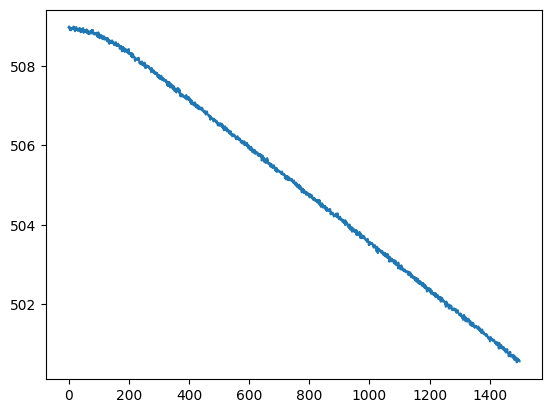

In [19]:
print(q_z.mean())
print(q_z.stddev())
plt.plot(losses)

In [20]:
theta_svi=q_z.mean()

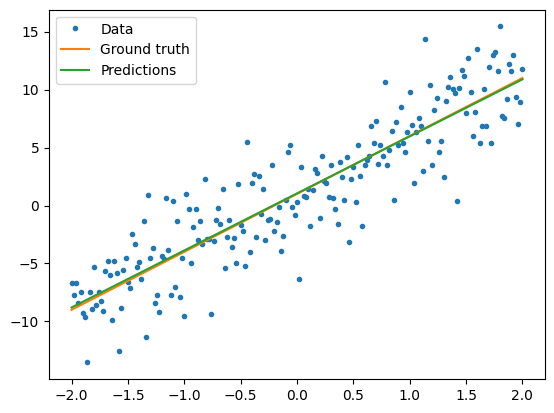

*
Current loss: 497.970490


In [21]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, theta_svi[0]*x+theta_svi[1], label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(theta_svi))

In [22]:
st=[1,2,3]
print(st)
print(np.squeeze(st))

l1=jax.tree_map(lambda x: x+1, np.squeeze(st))
print(np.shape(l1))

l2=jax.tree_map(lambda x: x+1, st)
print(np.shape(l2))

[1, 2, 3]
[1 2 3]
(3,)
(3,)


In [23]:
ex = np.array([1, 3])
m = np.array([1, 1, 4])

# Definir la función original que multiplica un elemento de ex por m
def multiplicar_elemento(ex_elem, m):
    return ex_elem * m

# Vectorizar la función usando jax.vmap
vectorized_multiplicacion = jax.vmap(multiplicar_elemento, in_axes=(0, None))

# Realizar la multiplicación para cada elemento de ex y m
resultado = vectorized_multiplicacion(ex, m)

# Transponer el resultado para obtener el formato deseado
resultado = np.transpose(resultado)

print(resultado)

[[ 1  3]
 [ 1  3]
 [ 4 12]]


In [24]:

ex=np.array([[1,3],[2,3],[4,5]])
m=np.array([1,1,4])
def mul(a,b):
  return a,b
vect=jax.vmap(loglikelihood, in_axes=(0))
r=vect(ex)
print(r)

print(loglikelihood([2,3]))

*
[-768.1161  -665.19135 -681.749  ]
*
-665.19135


In [25]:
 def HMC(

        q_z,
        init_eps=0.3,
        init_l=3,
        n_hmc=50,
        num_burnin_steps=250,
        num_results=750,
        max_leapfrog_steps=30,
        seed=0,
    ):
        dev_cnt = jax.device_count()
        seeds = jax.random.split(jax.random.PRNGKey(seed), dev_cnt)
        n_hmc = (n_hmc // dev_cnt) * dev_cnt
        momentum_distribution = tfd.MultivariateNormalFullCovariance(
            loc=jnp.zeros_like(q_z.mean()),
            covariance_matrix=jnp.linalg.inv(q_z.covariance()),
        )

        '''@jit
        def log_prob(z):
            return self.prob_model.log_prob(lens_sim, z)[0]'''




        @pmap
        def run_chain(seed):
            start = q_z.sample(n_hmc // dev_cnt, seed=seed)
            num_adaptation_steps = int(num_burnin_steps * 0.8)
            qz_params = jnp.squeeze(start) #this step could be removed
            print('shape of start',np.shape(start))


            mc_kernel = tfe.mcmc.PreconditionedHamiltonianMonteCarlo(
                target_log_prob_fn=jax.vmap(logposterior, in_axes=(0)),
                momentum_distribution=momentum_distribution,
                step_size=init_eps,
                num_leapfrog_steps=init_l,
            )

            mc_kernel = tfe.mcmc.GradientBasedTrajectoryLengthAdaptation(
                mc_kernel,
                num_adaptation_steps=num_adaptation_steps,
                max_leapfrog_steps=max_leapfrog_steps,
            )
            mc_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
                inner_kernel=mc_kernel, num_adaptation_steps=num_adaptation_steps
            )

            return tfp.mcmc.sample_chain(
                num_results=num_results,
                num_burnin_steps=num_burnin_steps,
                current_state=start,
                trace_fn=lambda _, pkr: None,
                seed=seed,
                kernel=mc_kernel,
            )

        start = time.time()
        ret = run_chain(seeds)
        end = time.time()
        print(f"Sampling took {(end - start):.1f}s")
        return ret

In [26]:
samples,sample_stats= HMC(q_z,init_eps=0.3,
        init_l=3,
        n_hmc=25,
        num_burnin_steps=250,
        num_results=750,
        max_leapfrog_steps=30,
        seed=0,
    )

shape of start (25, 2)
*
*
Sampling took 2.9s


In [27]:
print(np.shape(samples))
samples_res=np.reshape(samples,(750,25,2))
print(np.shape(samples_res))

(1, 750, 25, 2)
(750, 25, 2)


In [28]:
Rhat = tfp.mcmc.potential_scale_reduction(np.array(samples_res))
print(Rhat)

[1.0007135 1.0009687]


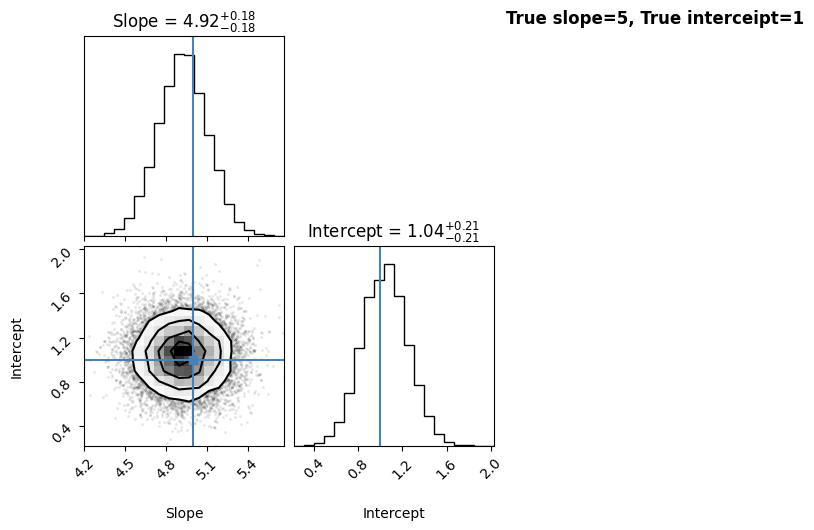

In [29]:
shape_samples=25*750
samples_res=np.array(samples_res)
s_R2=samples_res.reshape((shape_samples,2)) #2 comes from the number of parameters
truths=[5,1]
figure=corner(s_R2, show_titles=True,truths=truths,labels=['Slope', 'Intercept'])
plt.figtext(0.95, 0.95, 'True slope=5, True interceipt=1', color='black', weight='bold', size='large')
plt.show()

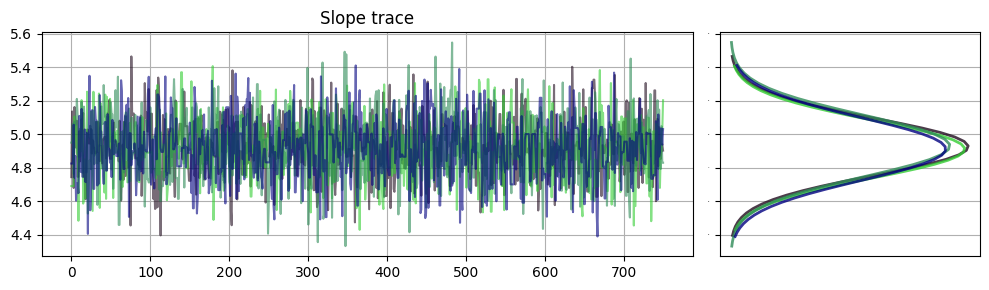

In [30]:
from scipy.stats import norm
colors = ['#1f0a1d','limegreen','seagreen','navy','darkkhaki']
fig = plt.figure(figsize=(10, 3))
gs = plt.GridSpec(1, 2, width_ratios=[1, .4], height_ratios=[1])
ax1 = plt.subplot(gs[0, 0],)

for i in range(4):
 ax1.plot(samples_res[:,i,0], colors[i], label = f'{i}', alpha = 0.6)
 plt.title('Slope trace')
#  plt.legend(title = 'Chains', loc = 'center left', bbox_to_anchor=(1.1, 0.5))

ax1.grid(True)

ax2 = plt.subplot(gs[0, 1], sharey=ax1)
for i in range(4):
  prob, bins = np.histogram(samples_res[:,i,0], density = True, bins = 40)
  (mu, sigma) = norm.fit(samples_res[:,i,0])

  y = norm.pdf(bins, mu, sigma)
  ax2.plot(y, bins, colors[i], linewidth=2, alpha = 0.8)

ax2.grid(True)
plt.gca().axes.get_xaxis().set_visible(False)
plt.tick_params(axis='y', labelsize=0)
plt.gca().axes.get_yaxis().set_visible(True)
plt.tight_layout()
plt.show()

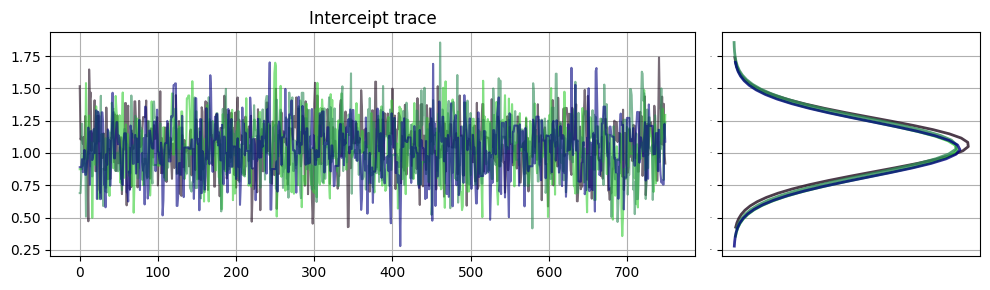

In [31]:
colors = ['#1f0a1d','limegreen','seagreen','navy','darkkhaki']
fig = plt.figure(figsize=(10, 3))
gs = plt.GridSpec(1, 2, width_ratios=[1, .4], height_ratios=[1])
ax1 = plt.subplot(gs[0, 0],)

for i in range(4):
 ax1.plot(samples_res[:,i,1], colors[i], label = f'{i}', alpha = 0.6)
 plt.title('Interceipt trace')
#  plt.legend(title = 'Chains', loc = 'center left', bbox_to_anchor=(1.1, 0.5))

ax1.grid(True)

ax2 = plt.subplot(gs[0, 1], sharey=ax1)
for i in range(4):
  prob, bins = np.histogram(samples_res[:,i,1], density = True, bins = 40)
  (mu, sigma) = norm.fit(samples_res[:,i,1])

  y = norm.pdf(bins, mu, sigma)
  ax2.plot(y, bins, colors[i], linewidth=2, alpha = 0.8)

ax2.grid(True)
plt.gca().axes.get_xaxis().set_visible(False)
plt.tick_params(axis='y', labelsize=0)
plt.gca().axes.get_yaxis().set_visible(True)
plt.tight_layout()
plt.show()